## Введение в глубокое обучение
### Занятие 7. Языковое моделирование и RNN

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev
##### Credits: Based on the notebook by [YSDA Practical RL course](https://github.com/yandexdataschool/Practical_RL/)

#### План занятия:
1. Введение в работу с последовательностями.
2. Принципы работы рекуррентных нейронных сетей.
3. Предобработка текстовых данных для задачи языкового моделирования.
4. Построение рекуррентной нейронной сети для задачи языкового моделирования.

### 1. Введение в работу с последовательностями.

__Go to slides__

### 2. Принципы работы рекуррентных нейронных сетей.

__Go to slides__

### 3. Предобработка текстовых данных для задачи языкового моделирования.
Рассмотрим набор данных, который представляет собой список имен. Каждая последовательность – отдельное имя. В качестве токенов будем рассматривать отдельные символы.

In [ ]:
import os
from random import sample

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython.display import clear_output

Загрузим и предобработаем данные:

In [ ]:
! wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/names -O names.txt

--2022-11-16 13:07:06--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55868 (55K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>]  54.56K  --.-KB/s    in 0.01s   

2022-11-16 13:07:07 (3.98 MB/s) - ‘names.txt’ saved [55868/55868]



In [ ]:
!head names.txt

Abagael
Abagail
Abbe
Abbey
Abbi
Abbie
Abby
Abigael
Abigail
Abigale


In [ ]:
start_token = " "

with open("names.txt") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token + line for line in names]

Как видим, в датасете 7944 примера. Обратите внимание, каждая последовательность начинается с пробела.

In [ ]:
a = [1,2,3,4,5]

In [ ]:
a[::-1]

[5, 4, 3, 2, 1]

In [ ]:
print ('n_samples = ',len(names))
for x in names[::1000]:
    print (x)

n_samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


Рассмотрим распределение длин последовательностей:

max_length = 16


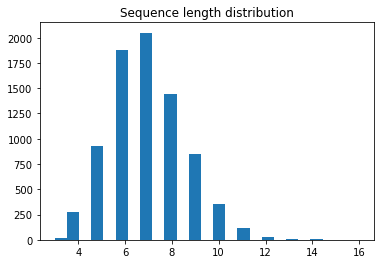

In [ ]:
MAX_LENGTH = max(map(len, names))
print("max_length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)),bins=25);

#### Предобработка текста

Для начала построим "словарь" из всех уникальных токенов и пронумеруем их. Тогда мы можем кодировать входные данные как последовательность их индексов символов. Например, имя "Aboba" будет представлено как `[0, 1, 15, 1, 0]`.

In [ ]:
set('aaaaaabbbbcc')

{'a', 'b', 'c'}

In [ ]:
tokens = set() # <set of all unique characters in the dataset>

for name in names:
    tokens.update(set(name))
tokens = list(tokens)

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  55


In [ ]:
# <dictionary of symbol -> its identifier (index in tokens list)>
token_to_id = {
    token: idx for idx, token in enumerate(tokens)
}

Теперь каждому соответствует уникальный индекс.

Наконец, реализуем функцию для преобразования список имен в матричное представление, которое в дальнейшем будет использоваться в качестве батча.
Т.к. тексты могут быть различной длины, дополним их до максимальной длины `max_len` или до длины самого длинного имени из выборки, если этот параметр не указан.

In [ ]:
def to_matrix(names, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first=True):
    """Casts a list of names into rnn-digestable matrix"""

    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_id[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix

    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

Рассмотрим пример:

In [ ]:
print('\n'.join(names[::1000]))
print(to_matrix(names[::1000]))

 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy
[[54 27  6 37 10 37 20 18 54]
 [54  2 18 37 38 20 48 36 37]
 [54  0 18 53 38 16 54 54 54]
 [54 19 40 18 40 37 21 20 54]
 [54 49 38 40 48 48 40 20 54]
 [54  0 20 20 36 37 54 54 54]
 [54  0 40 53 28 37 21 21 20]
 [54 49 40 10 10 16 54 54 54]]


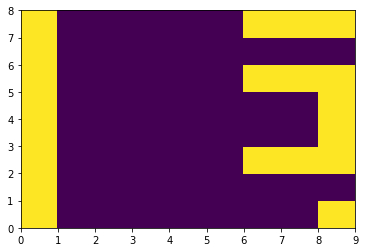

In [ ]:
plt.pcolormesh(to_matrix(names[::1000])==token_to_id[' ']
)

#### 4. Построение рекуррентной нейронной сети для задачи языкового моделирования.
Наконец, перейдем непосредственно к построению рекуррентной нейронной сети. Сегодня мы реализуем ее с нуля. Готовый вариант доступен, например, в `torch.nn.RNN`.

Рекуррентную нейронную сеть можно рассматривать как последовательное применение плотного слоя к входу $x_t$ и предыдущему состоянию `rnn` $h_t$.
<img src="https://raw.githubusercontent.com/neychev/small_DL_repo/master/rnn.png" width=480>

Также нам понадобятся:
* Embedding-слой, который преобразует индекс токена $x_t$ в вектор. Принцип его действия аналогичен word2vec, который был рассмотрен ранее. Основное отличие: параметры обучаются непосредственно на данную задачу.
* Выходной слой, который предсказывает вероятность следующего токена.

In [ ]:
embed = nn.Embedding(10, 4)

In [ ]:
params = next(iter(embed.parameters()))

In [ ]:
params

Parameter containing:
tensor([[ 0.2693,  0.9332, -0.1111, -0.4270],
        [ 0.0444, -0.5592, -0.8744, -0.7418],
        [ 0.2386,  0.4930, -2.0435, -0.0644],
        [ 1.3881,  1.2007, -1.0599,  0.1379],
        [ 0.3993, -0.3501, -0.9837,  0.9892],
        [ 0.6195,  1.7767, -1.9032,  2.7027],
        [-0.1361, -0.9275,  0.4515, -0.6125],
        [ 1.2407, -0.7534, -0.6731,  0.0938],
        [ 0.0592, -2.7567, -1.1671,  0.2825],
        [-0.6068,  0.0691,  1.1062,  0.1162]], requires_grad=True)

In [ ]:
embed(torch.LongTensor([1]))

tensor([[ 0.0444, -0.5592, -0.8744, -0.7418]], grad_fn=<EmbeddingBackward0>)

In [ ]:
type(torch.LongTensor([1]))

torch.Tensor

In [ ]:
vector = torch.zeros(10)
vector[1] = 1
print(vector)

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


In [ ]:
torch.matmul(vector, params)

tensor([ 0.0444, -0.5592, -0.8744, -0.7418], grad_fn=<SqueezeBackward3>)

In [ ]:
embed(torch.LongTensor([1]))

tensor([[ 0.0444, -0.5592, -0.8744, -0.7418]], grad_fn=<EmbeddingBackward0>)

In [ ]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        # batch, seq leng, emb dim
        x_emb = self.embedding(x)

        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([h_prev, x_emb], dim=-1) # YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) # YOUR CODE HERE

        h_next = torch.tanh(h_next) # YOUR CODE HERE

        assert h_next.size() == h_prev.size()

        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next) # YOUR CODE

        return h_next, logits

    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [ ]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()

Теперь реализуем функцию для обработки каждого следующего элемента последовательности:

In [ ]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logits = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(F.log_softmax(logits, -1))

    return torch.stack(logprobs, dim=1)

Наконец, проверим, что все работает:

In [ ]:
batch_ix = to_matrix(names[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

#### Обучение языковой модели

Т.к. задача предсказания следующего токена – это задача классификации, в качестве функции потерь будет выступать уже знакомая нам кросс-энтропия.

В качестве "истинных значений" мы будем использовать `batch_ix[:, 1:]` - матрицу из индексов токенов, сдвинутых на один шаг вперед.

In [ ]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

loss = criterion(
    predictions_logp.contiguous().view(-1, num_tokens),
    actual_next_tokens.contiguous().view(-1)
)

loss.backward()

Финальная проверка:

In [ ]:
for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

#### Обучение модели

Сама процедура обучения практически не отличается от предыдущих. Единственное различие заключается в том, что в этот раз мы семплируем строки переменной длины, а затем приводим их к единой длине внутри одного батча.

In [ ]:
char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

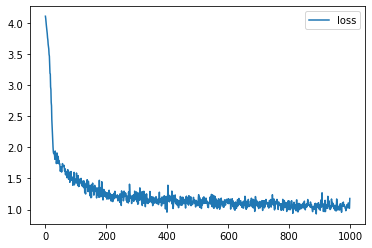

In [ ]:
MAX_LENGTH = 16

for i in range(1000):
    opt.zero_grad()

    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = rnn_loop(char_rnn, batch_ix)

    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    )

    # train with backprop
    loss.backward()
    opt.step()


    history.append(loss.item())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

#### Генерация имен
После обучения языковой модели (а обученная нейросеть является языковой моделью) перейдем к генерации данных.
Для этого воспользуемся функцией ниже:

In [ ]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

Рассмотрим несколько случайных примеров:

In [ ]:
for _ in range(10):
    print(generate_sample(char_rnn, temperature=1.))

 Deelled-       
 Lazyn          
 Rqylla         
 Sapfifa        
 Jainn          
 Migpeh         
 Leycena        
 Zlyl           
 Eurtaly        
 Jertaxie       


Также мы можем задать некоторую подстроку в для инициализации начального состояния нашей модели.

In [ ]:
for _ in range(50):
    print(generate_sample(char_rnn, seed_phrase=' Serg', temperature=1.))

 Sergis         
 Sergyem        
 Sergha         
 Serge          
 Serghin        
 Serg           
 Sergeilin      
 Serge          
 Sergie         
 Sergella       
 Sergtat        
 Sergaen        
 Sergi          
 Sergiis        
 Sergeete       
 Sergiei        
 Sergia         
 Sergeria       
 Serghey        
 Serghae        
 Sergefe        
 Sergie         
 Sergoen        
 Sergery        
 Serga          
 Sergoelret     
 Sergue         
 Sergoth        
 Sergay         
 Serg           
 Sergees        
 Serghept       
 Sergon         
 Serghy         
 Sergitha       
 Serge          
 Serga          
 Sergen         
 Sergie         
 Sergarate      
 Sergenhe       
 Serge          
 Sergaadi       
 Sergalle       
 Serge          
 Sergty         
 Sergio         
 Sergar         
 Serga          
 Sergkelvian    


#### Использование готовых модулей

Только что мы реализовали RNN самостоятельно, что полезно, но требует некоторого времени. Конечно, на практике обычно используются уже готовые реализации.

В `torch` доступны два варианта классической RNN:
* `nn.RNNCell(emb_size, rnn_num_units)`, которая реализует один шаг RNN. Аналог того класса, что мы реализовали выше.
* `nn.RNN(emb_size, rnn_num_units)`, которая самостоятельно обрабатывает всю последовательность (аналог `nn.RNNCell` + `rnn_loop`).


Также существуют `nn.LSTMCell` и `nn.LSTM`, `nn.GRUCell` и `nn.GRU`.

Воспользуемся высокоуровневым API для получения аналогичных результатов:

In [ ]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

In [ ]:
# the model applies over the whole sequence
batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
batch_ix = torch.LongTensor(batch_ix)

logp_seq = model(batch_ix)

loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, num_tokens),
                  batch_ix[:, :-1].contiguous().view(-1))

loss.backward()

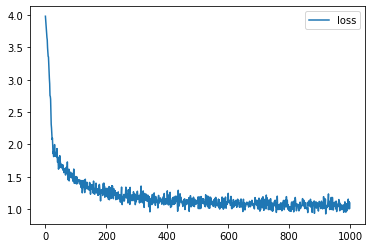

In [ ]:
MAX_LENGTH = 16

for i in range(1000):
    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = model(batch_ix)

    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    )

    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()

    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

#### Выводы:
* Рекуррентные нейронные сети позволяют работать с последовательностями переменной длины, обрабатывая по одному элементу за шаг.
* Задача языкового моделирования может рассматриваться как задача классификации, т.к. множество токенов конечно.
* Даже сложные модели могут быть реализованы с нуля. Но многие модули уже доступны в самом фреймворке.